<a href="https://colab.research.google.com/github/AndoneSabin99/232098_229701/blob/main/232098_229701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Deep Learning Project 2022 - Unsupervised Domain Adaptation
## Sabin Andone - Jacopo Clocchiatti



##Introduction
For the purpose of this project it was requested to realize a deep learning framework that could be trained and evaluated on a UDA (Unsupervised Domain Adaptation) setting. UDA is basically transfering the knowledge of a label-rich source domain to an unlabelled target domain. However, there are two issues to consider in this case:

1.   domain shift: the two domains are distributed on different manifolds and for this reason there is a domain gap across domains
2.   it is not allowed to have labels on target domain: in order to train supervisedly on the source domain and, at the same time, unsupervisedly on the target domain it is necessary to implement methods that does not require having labels on the target domain.

Considering these two points, it nas been choosen to implement an adversarial method for UDA.

##The Adaptiope Dataset
Adaptiope dataset contains images belonging to 3 different domains, each containing 123 categories. Since this dataset contains a lot of images, for the purpose of this project it is necessary to only get 2 "domains" from the dataset: the **product images** and **the real life**. For both of these domains, we only consider 20 categories from the 123 categories in the original dataset. These categories are: backpack, bookcase, car jack, comb, crown, file cabinet, flat iron, game controller,
glasses, helicopter, ice skates, letter tray, monitor, mug, network switch, over-ear headphones, pen, purse, stand mixer and stroller.


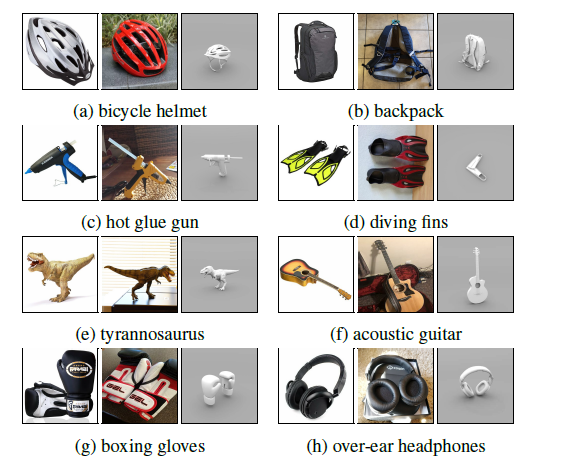

##Data Setup
First, in order to be able to train and to evaluate the UDA framework proposed for this project, it is necessary to load the data from the Adaptiope object recognition dataset, which is publicly available for [download](https://drive.google.com/file/d/1FmdsvetC0oVyrFJ9ER7fcN-cXPOWx2gq/view). To do this, it is necessary to store the data on the 'datasets' folder and the mount the Google Drive folder on Colab. Since it is also hosted on Google Drive, it is possible to access the dataset without downloading it by just adding a Google Drive shortcut on the folder.

First we import the necessary libraries for this part.

In [1]:
import os
from os import listdir
from os.path import join, isfile
from tqdm import tqdm
from google.colab import drive
from shutil import copytree

Now, we mount the google drive file in order to get the Adaptiope.zip file and put it in our dataset directory

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!mkdir dataset
!cp "gdrive/My Drive/datasets/Adaptiope.zip" dataset/
!ls dataset

Adaptiope.zip


In [ ]:
!unzip dataset/Adaptiope.zip

As said before in the Dataset section, we only get 2 domains and 20 categories for each domain. So it is necessary to create a new directory called adaptiope_small and put all the necessary data there from the original dataset.

In [5]:
!rm -rf adaptiope_small

In [6]:
!mkdir adaptiope_small
classes = listdir("Adaptiope/product_images")
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  os.makedirs(td, exist_ok=True)
  for c in tqdm(classes):
    c_path = join(d, c)
    c_target = join(td, c)
    copytree(c_path, c_target)

100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


In [ ]:
!ls adaptiope_small/real_life/

 backpack   'file cabinet'     'ice skates'	 'over-ear headphones'
 bookcase   'flat iron'        'letter tray'	  pen
'car jack'  'game controller'   monitor		  purse
 comb	     glasses	        mug		 'stand mixer'
 crown	     helicopter        'network switch'   stroller


In [ ]:
os.path.exists('/content/adaptiope_small/real_life')

True

Once the dataset is corretly setup on Colab, it is possible to start with the actual coding part. First, it is necessary to import the following libraries:

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import os
from torch.utils.tensorboard import SummaryWriter

##GPu functions
GPU functions, necessary to run the model in a reasonable amount of time.

In [8]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [9]:
device = get_default_device()

In [10]:
def to_device(data, device):
    #Move tensor(ot tensors) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [11]:
class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        #The yield keyword in Python is used to create a generator function that can be used within a for loop,
        for b in self.dl: 
            yield to_device(b, self.device) 

    def __len__(self):
        #Return the number of batches
        return len(self.dl)

## Data loading
Get_data(...) is a method that aims to compactly return the dataloaders that we need, introducing some transformations. In our specific case, we have to specify the source domain and the target domain.

In [13]:
'''
Input arguments:
  batch_size: mini batch size used during training
  img_root: path to the dataset parent folder. 
            The folder just above the sub-folders or class folders
'''

def get_data(batch_size, img_root_source, img_root_target):
  
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((256, 256)))                      # resize each PIL image to 256 x 256
  transform.append(T.RandomCrop((224, 224)))                  # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  transform = T.Compose(transform)                            # compose the above transformations into one
    
  # load source domain data
  dataset_source = torchvision.datasets.ImageFolder(root=img_root_source, transform=transform)

  # load target domain data
  dataset_target = torchvision.datasets.ImageFolder(root=img_root_target, transform=transform)
  
  # create train and test splits (80/20) for source domain
  num_samples_source = len(dataset_source)
  source_training_samples = int(num_samples_source * 0.8 + 1)
  source_test_samples = num_samples_source - source_training_samples

  source_training_data, source_test_data = torch.utils.data.random_split(dataset_source, 
                                                           [source_training_samples, source_test_samples])

  #repeat the train and test splits for the target domain
  num_samples_target = len(dataset_target)
  target_training_samples = int(num_samples_target * 0.8 + 1)
  target_test_samples = num_samples_target - target_training_samples

  target_training_data, target_test_data = torch.utils.data.random_split(dataset_target, 
                                                           [target_training_samples, target_test_samples])

  # initialize dataloaders
  #PS: source_test_loader is not necessary since we are training on source_train and target_train and testing only on target_test
  source_train_loader = torch.utils.data.DataLoader(source_training_data, batch_size, shuffle=True)
  #source_test_loader = torch.utils.data.DataLoader(source_test_data, batch_size, shuffle=False)
  target_train_loader = torch.utils.data.DataLoader(target_training_data, batch_size, shuffle=True)
  target_test_loader = torch.utils.data.DataLoader(target_test_data, batch_size, shuffle=False)
  
  return source_train_loader, target_train_loader,target_test_loader

## Network Definition


In [14]:
#import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
#import torch
#import ipdb


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet50(pretrained, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    # modify the structure of the model
    num_of_feature_map = model.fc.in_features
    model.fc = nn.Linear(num_of_feature_map, 20 + 1)
    model_dict = model.state_dict()
    if pretrained:
      pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
      pretrained_dict.pop('fc.weight')
      pretrained_dict.pop('fc.bias')
      model_dict.update(pretrained_dict)
      model.load_state_dict(model_dict)

    return model

## Cost function
For the source domain, since we are provided with **label information**, it is possible to use the usual cross-entropy classification loss. On the other hand, we can define for the **unlabelled** target domain an entropy loss meant to maximally separate the unlabelled data.

$L^{t}(\theta) = - \frac{1}{m} \displaystyle \sum^{m}_{i=1} p_{i}\log{p_i}$

In [15]:
def get_ce_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

def get_entropy_loss(x):
  p = F.softmax(x, dim=1)
  q = F.log_softmax(x, dim=1)
  b = p * q
  b = -1.0 * b.sum(-1).mean()
  return b

## Optimizer
As usual, a stochastic gradient descent optimizer can be employed 

In [16]:
def get_optimizer(net, lr, wd, momentum):
  #optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  optimizer = torch.optim.SGD(net, lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

## Training and test steps
We define our training and test steps for the UDA experiment. In this case we have to choose one of the two domains as the source domain and the other one as the target domain. After doing such decision, we train **supervisedly** on the source domain and **unsupervisedly** on the target domain. The testing step must be done on the target domain. After the evaluation, we repeat the experiment by swapping the source domain with the target domain (i.e. switching the direction of the domain shift)
(TODO: adapt in base of the feature extractor if necessary)

In [17]:
def training_step_sup(net, data_loader, optimizer, cost_function, device='cuda'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to training mode: particularly important when using dropout!
  net.train() 

  # iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):

    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # forward pass
    outputs = net(inputs)

    # loss computation
    loss = cost_function(outputs,targets)

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def training_step(net, source_data_loader, target_data_loader, optimizer, 
          get_ce_cost_function, entropy_loss_weight, device='cuda:0'):
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_en_loss = 0.
  cumulative_accuracy = 0.
  
  target_iter = iter(target_data_loader)

  # strictly needed if network contains layers which has different behaviours between train and test
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    
    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter)
    except:
      target_iter = iter(target_data_loader)
      inputs_target, _ = next(target_iter)
    
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    
    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # forward pass
    outputs = net(inputs)
    
    # split the source and target outputs
    source_output, target_output = torch.split(outputs, 
                                               split_size_or_sections=outputs.shape[0] // 2, 
                                               dim=0)
    
    # apply the losses
    ce_loss = get_ce_cost_function(source_output,targets)
    en_loss = get_entropy_loss(target_output)
    
    loss = ce_loss + entropy_loss_weight * en_loss
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # reset the optimizer
    optimizer.zero_grad()

    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    
    cumulative_ce_loss += ce_loss.item()
    cumulative_en_loss += en_loss.item()
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_en_loss/target_samples, cumulative_accuracy/source_samples*100


def test_step(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # strictly needed if network contains layers which has different behaviours between train and test
  net.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      outputs = net(inputs)

      # apply the loss
      loss = cost_function(outputs, targets)

      # print statistics
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

##The main function (WIP...)

In [20]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=10,
         entropy_loss_weight=0.1,
         img_root_pi=None,
         img_root_rl=None,
         target=None):
  
  #we choose the source and the target domains
  if (target == 'real_life'):
    source_train_loader, target_train_loader, target_test_loader = get_data(batch_size, img_root_pi, img_root_rl)
  else:
    source_train_loader, target_train_loader, target_test_loader = get_data(batch_size, img_root_rl, img_root_pi)

  source_train_loader = DeviceDataLoader(source_train_loader, device)
  #source_test_loader = DeviceDataLoader(source_test_loader, device)
  target_train_loader = DeviceDataLoader(target_train_loader, device)
  target_test_loader = DeviceDataLoader(target_test_loader, device)

  

  #must find a feature extractor/i.e. network definition as AlexNet is the one from the lab
  # instantiates the model

  #model = ProductImage()
  #load_pretrained_AlexNet(model.sharedNetwork, progress=True)
  

  #model = ResNet()
  
  model = resnet50(True)
  #to_device(model, device);

  model = torch.nn.DataParallel(model).cuda()

  
  #optimizer = get_optimizer(model, learning_rate, weight_decay, momentum)
  optimizer = get_optimizer([
            {'params': model.module.conv1.parameters(), 'name': 'pre-trained'},
            {'params': model.module.bn1.parameters(), 'name': 'pre-trained'},
            {'params': model.module.layer1.parameters(), 'name': 'pre-trained'},
            {'params': model.module.layer2.parameters(), 'name': 'pre-trained'},
            {'params': model.module.layer3.parameters(), 'name': 'pre-trained'},
            {'params': model.module.layer4.parameters(), 'name': 'pre-trained'},
            {'params': model.module.fc.parameters(), 'name': 'pre-trained'}
        ], 
        learning_rate, 
        weight_decay, 
        momentum)
  
  cost_function = get_ce_cost_function()

  #train supervisedly on source_train_loader using cross entropy loss as cost function
  #in the testing step we must choose the target_test_loader to get the acc_so accuracy

  #defining the acc_so variable, setting it to 0 as initial value. It will assume the maximum source only accuracy value
  acc_so = 0;
  for e in range(epochs):
    train_loss, train_accuracy = training_step_sup(model, source_train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test_step(model, target_test_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
    if (val_accuracy>acc_so):
      acc_so = val_accuracy

  print('\t acc_so: ',acc_so)

  #choose any UDA device for our project
  #In the training step, we have to train on both source_train-loader and on target_train_loader, respectively supervisedly and unsupervisedly
  #in the testing step we must choose the target_test_loader to get the acc_uda accuracy

  #PS: this is the code from lab

  #acc_uda = 0
  #for e in range(epochs):
    #train_ce_loss, train_en_loss, train_accuracy = training_step(net=model, source_data_loader=source_train_loader, 
                                                         #target_data_loader=target_train_loader, 
                                                         #optimizer=optimizer, get_ce_cost_function=cost_function,
                                                         #entropy_loss_weight=entropy_loss_weight)
   # test_loss, test_accuracy = test_step(model, target_test_loader, cost_function)
    
   # print('Epoch: {:d}'.format(e+1))
   # print('\t Train: CE loss {:.5f}, Entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_en_loss, train_accuracy))
   # print('\t Test: CE loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
   # print('-----------------------------------------------------')
   # if (test_accuracy>acc_uda):
     # acc_uda = test_accuracy

 # print('\t acc_uda: ',acc_uda)

  #Compute the gain as G = acc_uda - acc_so

  #G = acc_uda - acc_so
  #print('\t G: ', G)
  

To execute the program, we have to call the main function, giving the image roots of both domains as parameters. We also have to provide the direction of the domain shift in order to decide which domain will be the source domain and which one will be the target. So, we also specify in the input parameters the target domain.

##Product images --> Real life direction

In [21]:
main(img_root_pi = '/content/adaptiope_small/product_images', img_root_rl = '/content/adaptiope_small/real_life', target = 'real_life')

Epoch: 1
	 Training loss 0.01534, Training accuracy 56.59
	 Validation loss 0.00916, Validation accuracy 79.45
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00149, Training accuracy 96.69
	 Validation loss 0.00542, Validation accuracy 84.71
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00037, Training accuracy 98.94
	 Validation loss 0.00545, Validation accuracy 82.71
-----------------------------------------------------


KeyboardInterrupt: ignored

##Real life --> Product images direction

In [ ]:
main(img_root_pi = '/content/adaptiope_small/product_images', img_root_rl = '/content/adaptiope_small/real_life', target = 'product_images')